In [ ]:
import pandas as pd
import os

# Get the correct path to diabetes.csv
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go one level up
DATA_PATH = os.path.join(BASE_DIR, "diabetes.csv")

# Load dataset
try:
    df = pd.read_csv(DATA_PATH)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: File not found at {DATA_PATH}")
    df = None

# Display first few rows if file loaded
if df is not None:
    print(df.head())

    # Check for missing values
    print("\nMissing Values:\n", df.isnull().sum())

    # Check data distribution
    print("\nData Distribution:\n", df.describe())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
       Pregnancies  

Insulin
0    0.365482
1    0.329949
Name: Outcome, dtype: float64


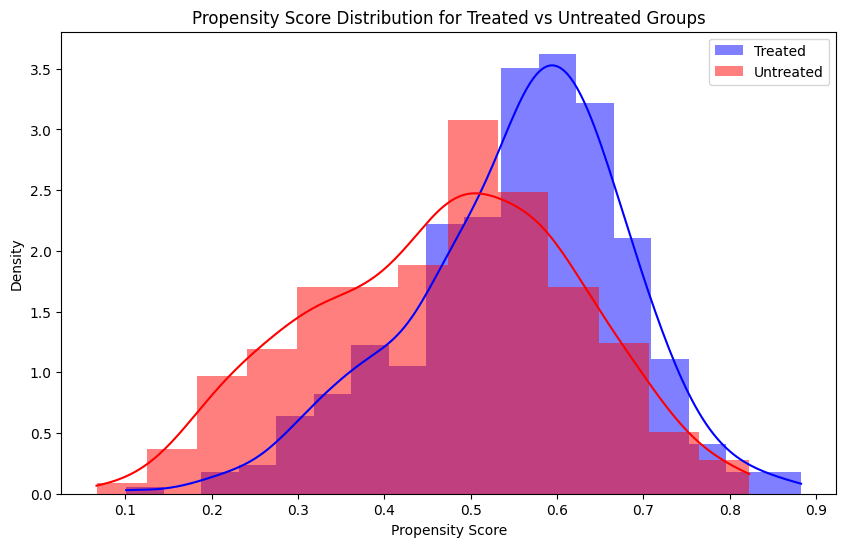

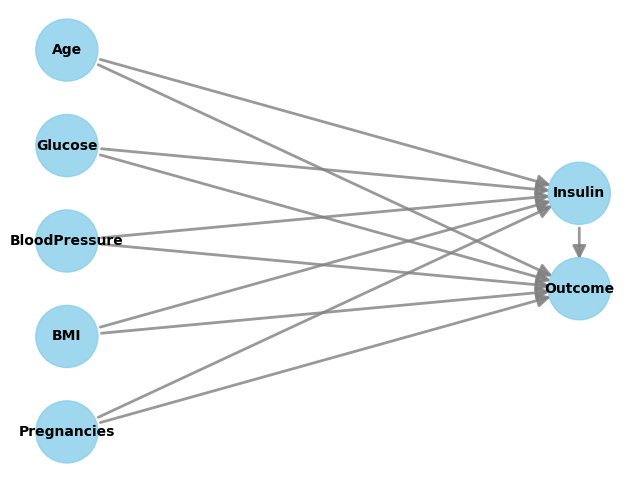

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from dowhy import CausalModel

# Assuming 'df' is already available (replace with your actual data loading line)
# Example: df = pd.read_csv("diabetes_data.csv")

# Define treatment, outcome, and confounders
treatment = "Insulin"  # Whether the patient received insulin (1 = Yes, 0 = No)
outcome = "Outcome"  # Diabetes diagnosis (0 = No, 1 = Yes)
confounders = ["Age", "BMI", "Glucose", "BloodPressure", "Pregnancies"]

# If the 'Insulin' variable is not binary, convert it to binary (1 = took insulin, 0 = did not)
df["Insulin"] = df["Insulin"].apply(lambda x: 1 if x > 0 else 0)

# Standardize confounders
scaler = StandardScaler()
X = scaler.fit_transform(df[confounders])

# Logistic regression model for propensity score
psm_model = LogisticRegression()
psm_model.fit(X, df[treatment])

# Compute propensity scores (probability of receiving the treatment)
df["propensity_score"] = psm_model.predict_proba(X)[:, 1]

# Perform nearest neighbor matching
treated = df[df[treatment] == 1]
untreated = df[df[treatment] == 0]

# Use NearestNeighbors to find the closest untreated match for each treated individual based on propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(untreated["propensity_score"].values.reshape(-1, 1))
_, indices = nn.kneighbors(treated["propensity_score"].values.reshape(-1, 1))

# Get matched untreated group
matched_untreated = untreated.iloc[indices.flatten()]

# Create the final matched dataset
matched_df = pd.concat([treated, matched_untreated])

# Compare diabetes outcomes between treated and matched untreated groups
outcome_comparison = matched_df.groupby(treatment)[outcome].mean()
print(outcome_comparison)

# Visualize the distribution of propensity scores for treated vs untreated groups
plt.figure(figsize=(10, 6))
sns.histplot(df[df[treatment] == 1]["propensity_score"], color="blue", label="Treated", kde=True, stat="density", linewidth=0)
sns.histplot(df[df[treatment] == 0]["propensity_score"], color="red", label="Untreated", kde=True, stat="density", linewidth=0)
plt.legend()
plt.title("Propensity Score Distribution for Treated vs Untreated Groups")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.show()

# Causal model visualization using DoWhy
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders
)

# Visualize the causal graph directly using DoWhy's view_model
model.view_model()



Estimated ATE (Average Treatment Effect): -0.04456601180404268
Conditional Average Treatment Effects (CATE) by Age Group: {'30-60': 0.018135735938557662, '0-30': -0.08388157317813222, '60+': -0.31918176009314586}


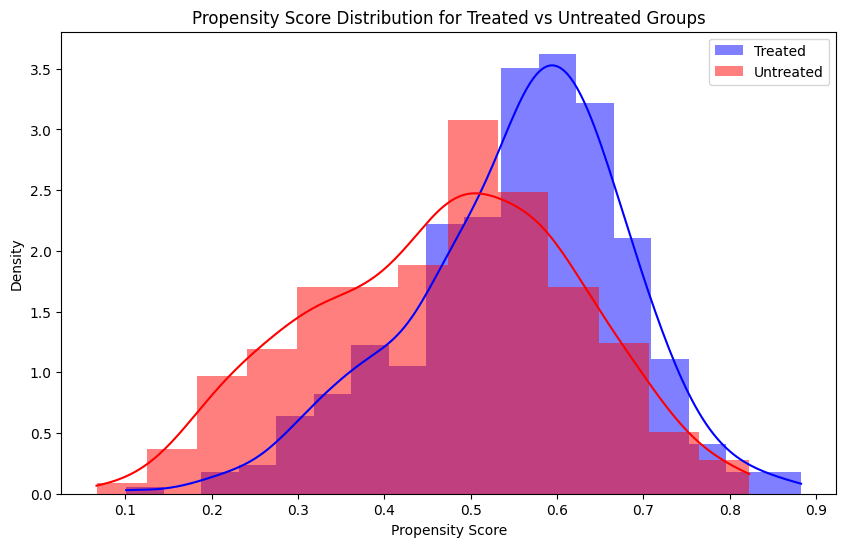

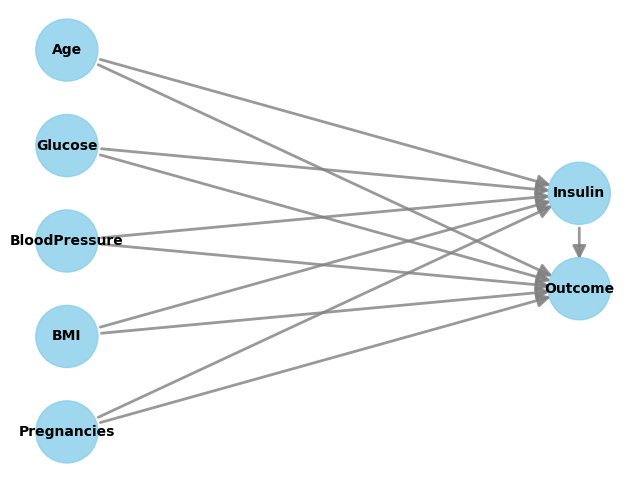

Simulated Outcome if treated: 1.0
Simulated Outcome if untreated: 0.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from dowhy import CausalModel
from sklearn.neighbors import NearestNeighbors

# Assuming 'df' is already available (replace with your actual data loading line)
# Example: df = pd.read_csv("diabetes_data.csv")

# Define treatment, outcome, and confounders
treatment = "Insulin"  # Whether the patient received insulin (1 = Yes, 0 = No)
outcome = "Outcome"  # Diabetes diagnosis (0 = No, 1 = Yes)
confounders = ["Age", "BMI", "Glucose", "BloodPressure", "Pregnancies"]

# If the 'Insulin' variable is not binary, convert it to binary (1 = took insulin, 0 = did not)
df["Insulin"] = df["Insulin"].apply(lambda x: 1 if x > 0 else 0)

# Standardize confounders
scaler = StandardScaler()
X = scaler.fit_transform(df[confounders])

# Logistic regression model for propensity score
psm_model = LogisticRegression()
psm_model.fit(X, df[treatment])

# Compute propensity scores (probability of receiving the treatment)
df["propensity_score"] = psm_model.predict_proba(X)[:, 1]

# Calculate Inverse Probability Weights (IPW)
df['ipw'] = np.where(df[treatment] == 1, 1 / df['propensity_score'], 1 / (1 - df['propensity_score']))

# Calculate the Weighted Outcome
weighted_outcome_treated = (df[treatment] == 1) * df[outcome] * df['ipw']
weighted_outcome_untreated = (df[treatment] == 0) * df[outcome] * df['ipw']

# Compute the Average Treatment Effect (ATE)
ATE = weighted_outcome_treated.sum() / df[df[treatment] == 1]['ipw'].sum() - \
      weighted_outcome_untreated.sum() / df[df[treatment] == 0]['ipw'].sum()

print(f"Estimated ATE (Average Treatment Effect): {ATE}")

# Calculate Conditional Average Treatment Effect (CATE) based on specific confounders
# For simplicity, let's compute CATE conditioned on "Age" by splitting the data
df['Age_group'] = pd.cut(df['Age'], bins=[0, 30, 60, np.inf], labels=['0-30', '30-60', '60+'])

cate_results = {}
for age_group in df['Age_group'].unique():
    subset = df[df['Age_group'] == age_group]
    
    weighted_outcome_treated_group = (subset[treatment] == 1) * subset[outcome] * subset['ipw']
    weighted_outcome_untreated_group = (subset[treatment] == 0) * subset[outcome] * subset['ipw']
    
    ATE_group = weighted_outcome_treated_group.sum() / subset[subset[treatment] == 1]['ipw'].sum() - \
                weighted_outcome_untreated_group.sum() / subset[subset[treatment] == 0]['ipw'].sum()
    
    cate_results[age_group] = ATE_group

print(f"Conditional Average Treatment Effects (CATE) by Age Group: {cate_results}")

# Visualize the distribution of propensity scores for treated vs untreated groups
plt.figure(figsize=(10, 6))
sns.histplot(df[df[treatment] == 1]["propensity_score"], color="blue", label="Treated", kde=True, stat="density", linewidth=0)
sns.histplot(df[df[treatment] == 0]["propensity_score"], color="red", label="Untreated", kde=True, stat="density", linewidth=0)
plt.legend()
plt.title("Propensity Score Distribution for Treated vs Untreated Groups")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.show()

# Causal model visualization using DoWhy
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders
)

# Visualize the causal graph directly using DoWhy's view_model
model.view_model()

# What-If Simulation
def what_if_simulation(treatment_value, confounders_values):
    """
    Simulate the potential outcome if the treatment was set to a given value.
    
    Args:
    - treatment_value: New treatment value (1 or 0).
    - confounders_values: Dictionary of confounder values.
    
    Returns:
    - Simulated outcome.
    """
    # Convert the confounder values into a pandas DataFrame with the same feature names
    confounders_values = pd.DataFrame([confounders_values], columns=confounders)
    
    # Standardize based on training data
    confounders_values = scaler.transform(confounders_values)  # Standardize
    
    propensity_score_sim = psm_model.predict_proba(confounders_values)[:, 1]
    ipw_sim = 1 / (propensity_score_sim if treatment_value == 1 else 1 - propensity_score_sim)
    
    # Create a synthetic dataset with the given treatment and confounder values
    simulated_data = pd.DataFrame(confounders_values, columns=confounders)
    simulated_data[treatment] = treatment_value
    simulated_data["propensity_score"] = propensity_score_sim
    simulated_data["ipw"] = ipw_sim
    
    # Calculate the weighted outcome for the simulated data
    simulated_weighted_outcome = simulated_data[treatment] * df[outcome] * simulated_data['ipw']
    
    # Simulate outcome prediction (this assumes we can directly model outcome for new observations)
    simulated_outcome = simulated_weighted_outcome.sum() / simulated_data['ipw'].sum()
    
    return simulated_outcome

# Example of What-If simulation for a patient with specific confounders values
confounder_example = {
    "Age": 45,
    "BMI": 28,
    "Glucose": 120,
    "BloodPressure": 80,
    "Pregnancies": 2
}

simulated_outcome_treated = what_if_simulation(treatment_value=1, confounders_values=confounder_example)
simulated_outcome_untreated = what_if_simulation(treatment_value=0, confounders_values=confounder_example)

print(f"Simulated Outcome if treated: {simulated_outcome_treated}")
print(f"Simulated Outcome if untreated: {simulated_outcome_untreated}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from dowhy import CausalModel
import scipy.stats as stats

# Load data
# Replace this with your actual data loading code
# For example: df = pd.read_csv("diabetes_data.csv")
# This is just a placeholder assuming df exists

# Define treatment, outcome, and confounders
treatment = "Insulin"  # Whether the patient received insulin (1 = Yes, 0 = No)
outcome = "Outcome"    # Diabetes diagnosis (0 = No, 1 = Yes)
confounders = ["Age", "BMI", "Glucose", "BloodPressure", "Pregnancies"]

# If the 'Insulin' variable is not binary, convert it to binary (1 = took insulin, 0 = did not)
df["Insulin"] = df["Insulin"].apply(lambda x: 1 if x > 0 else 0)

# Standardize confounders
scaler = StandardScaler()
X = scaler.fit_transform(df[confounders])

# Logistic regression model for propensity score
psm_model = LogisticRegression()
psm_model.fit(X, df[treatment])

# Compute propensity scores (probability of receiving the treatment)
df["propensity_score"] = psm_model.predict_proba(X)[:, 1]

# Calculate Inverse Probability Weights (IPW)
df['ipw'] = np.where(df[treatment] == 1, 1 / df['propensity_score'], 1 / (1 - df['propensity_score']))

# VALIDATION 1: Trim extreme weights
weight_percentile = np.percentile(df['ipw'], 95)
df['ipw_trimmed'] = np.minimum(df['ipw'], weight_percentile)

# VALIDATION 2: Check propensity score distributions
plt.figure(figsize=(10, 6))
sns.histplot(df[df[treatment] == 1]["propensity_score"], color="blue", label="Treated", kde=True, stat="density", linewidth=0)
sns.histplot(df[df[treatment] == 0]["propensity_score"], color="red", label="Untreated", kde=True, stat="density", linewidth=0)
plt.legend()
plt.title("Propensity Score Distribution for Treated vs Untreated Groups")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.savefig("propensity_distribution.png")
plt.close()

# VALIDATION 3: Check covariate balance before and after weighting
balance_results = pd.DataFrame(columns=["Confounder", "Unweighted_SMD", "Weighted_SMD"])

for i, confounder in enumerate(confounders):
    # Unweighted means
    treated_mean_unw = df[df[treatment]==1][confounder].mean()
    control_mean_unw = df[df[treatment]==0][confounder].mean()
    
    # Weighted means
    treated_mean_w = (df[df[treatment]==1][confounder] * df[df[treatment]==1]['ipw_trimmed']).sum() / df[df[treatment]==1]['ipw_trimmed'].sum()
    control_mean_w = (df[df[treatment]==0][confounder] * df[df[treatment]==0]['ipw_trimmed']).sum() / df[df[treatment]==0]['ipw_trimmed'].sum()
    
    # Calculate standardized mean differences
    std_diff_unw = (treated_mean_unw - control_mean_unw) / df[confounder].std()
    std_diff_w = (treated_mean_w - control_mean_w) / df[confounder].std()
    
    balance_results.loc[i] = [confounder, std_diff_unw, std_diff_w]

print("Covariate Balance Check:")
print(balance_results)

# Create love plot to visualize balance
plt.figure(figsize=(10, 6))
balance_plot = pd.melt(balance_results, id_vars=['Confounder'], 
                        value_vars=['Unweighted_SMD', 'Weighted_SMD'],
                        var_name='Method', value_name='Standardized Mean Difference')
sns.barplot(x='Standardized Mean Difference', y='Confounder', hue='Method', data=balance_plot)
plt.axvline(x=0.1, color='red', linestyle='--', label='Threshold (0.1)')
plt.title("Covariate Balance Before and After Weighting")
plt.legend()
plt.tight_layout()
plt.savefig("balance_plot.png")
plt.close()

# Calculate the ATE with trimmed weights
weighted_outcome_treated = (df[treatment] == 1) * df[outcome] * df['ipw_trimmed']
weighted_outcome_untreated = (df[treatment] == 0) * df[outcome] * df['ipw_trimmed']

ATE = weighted_outcome_treated.sum() / df[df[treatment] == 1]['ipw_trimmed'].sum() - \
      weighted_outcome_untreated.sum() / df[df[treatment] == 0]['ipw_trimmed'].sum()

print(f"Estimated ATE (Average Treatment Effect) with trimmed weights: {ATE}")

# VALIDATION 4: Implement doubly-robust estimator (AIPW)
# Outcome model
outcome_model = LogisticRegression()
outcome_model.fit(X, df[outcome])
df['predicted_outcome'] = outcome_model.predict_proba(X)[:, 1]

# Augmented IPW (AIPW) estimator
aipw_effect = ((df[treatment] * (df[outcome] - df['predicted_outcome'])) / df['propensity_score']).mean() - \
              (((1-df[treatment]) * (df[outcome] - df['predicted_outcome'])) / (1-df['propensity_score'])).mean() + \
              (df['predicted_outcome'] * (2*df[treatment] - 1)).mean()

print(f"Doubly-robust ATE estimate (AIPW): {aipw_effect}")

# Calculate Conditional Average Treatment Effect (CATE) based on age groups
df['Age_group'] = pd.cut(df['Age'], bins=[0, 30, 60, np.inf], labels=['0-30', '30-60', '60+'])

# VALIDATION 5: Check sample sizes and overlap by age group
print("\nAge Group Analysis:")
for age_group in df['Age_group'].unique():
    subset = df[df['Age_group'] == age_group]
    treated = subset[subset[treatment]==1]
    control = subset[subset[treatment]==0]
    print(f"Age group {age_group}:")
    print(f"  Sample size: {len(treated)} treated, {len(control)} control")
    print(f"  Propensity range treated: {treated['propensity_score'].min():.3f}-{treated['propensity_score'].max():.3f}")
    print(f"  Propensity range control: {control['propensity_score'].min():.3f}-{control['propensity_score'].max():.3f}")

# Calculate CATE with trimmed weights
cate_results = {}
cate_aipw_results = {}

for age_group in df['Age_group'].unique():
    subset = df[df['Age_group'] == age_group]
    
    # IPW estimate
    weighted_outcome_treated_group = (subset[treatment] == 1) * subset[outcome] * subset['ipw_trimmed']
    weighted_outcome_untreated_group = (subset[treatment] == 0) * subset[outcome] * subset['ipw_trimmed']
    
    # Handle potential division by zero
    treated_sum = subset[subset[treatment] == 1]['ipw_trimmed'].sum()
    untreated_sum = subset[subset[treatment] == 0]['ipw_trimmed'].sum()
    
    if treated_sum > 0 and untreated_sum > 0:
        ATE_group = weighted_outcome_treated_group.sum() / treated_sum - \
                    weighted_outcome_untreated_group.sum() / untreated_sum
        cate_results[age_group] = ATE_group
    else:
        cate_results[age_group] = np.nan
        print(f"Warning: Insufficient data for {age_group} - treated_sum: {treated_sum}, untreated_sum: {untreated_sum}")
    
    # AIPW estimate for each group
    if len(subset) > 10:  # Require minimum sample size
        aipw_group = ((subset[treatment] * (subset[outcome] - subset['predicted_outcome'])) / subset['propensity_score']).mean() - \
                     (((1-subset[treatment]) * (subset[outcome] - subset['predicted_outcome'])) / (1-subset['propensity_score'])).mean() + \
                     (subset['predicted_outcome'] * (2*subset[treatment] - 1)).mean()
        cate_aipw_results[age_group] = aipw_group
    else:
        cate_aipw_results[age_group] = np.nan

print(f"\nConditional Average Treatment Effects (CATE) by Age Group (IPW): {cate_results}")
print(f"Conditional Average Treatment Effects (CATE) by Age Group (AIPW): {cate_aipw_results}")

# Visualize CATE by age group
plt.figure(figsize=(10, 6))
age_groups = list(cate_results.keys())
ipw_values = [cate_results[g] if not np.isnan(cate_results[g]) else 0 for g in age_groups]
aipw_values = [cate_aipw_results[g] if g in cate_aipw_results and not np.isnan(cate_aipw_results[g]) else 0 for g in age_groups]

x = np.arange(len(age_groups))
width = 0.35

plt.bar(x - width/2, ipw_values, width, label='IPW')
plt.bar(x + width/2, aipw_values, width, label='AIPW')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Age Group')
plt.ylabel('Treatment Effect')
plt.title('Treatment Effect by Age Group')
plt.xticks(x, age_groups)
plt.legend()
plt.savefig("cate_by_age.png")
plt.close()

# VALIDATION 6: Sensitivity analysis for unmeasured confounding
print("\nSensitivity Analysis for Unmeasured Confounding:")
ate_sensitivity = {}

# Create synthetic confounders with varying strengths
for gamma in [1.0, 1.5, 2.0, 3.0]:
    # Simulate a confounder that affects both treatment and outcome
    np.random.seed(42)  # For reproducibility
    # Higher gamma means stronger association with treatment
    unmeasured = gamma * df[treatment] + np.random.normal(0, 1, len(df))
    
    # Add to dataframe
    df['unmeasured'] = unmeasured
    
    # Include in propensity model
    X_sens = np.column_stack((X, df['unmeasured'].values.reshape(-1, 1)))
    
    # New propensity model with unmeasured confounder
    psm_model_sens = LogisticRegression()
    psm_model_sens.fit(X_sens, df[treatment])
    
    # New propensity scores
    df["propensity_score_sens"] = psm_model_sens.predict_proba(X_sens)[:, 1]
    
    # New weights
    df['ipw_sens'] = np.where(df[treatment] == 1, 
                              1 / df['propensity_score_sens'], 
                              1 / (1 - df['propensity_score_sens']))
    
    # Trim weights
    weight_percentile = np.percentile(df['ipw_sens'], 95)
    df['ipw_sens_trimmed'] = np.minimum(df['ipw_sens'], weight_percentile)
    
    # Calculate ATE with sensitivity analysis
    weighted_outcome_treated = (df[treatment] == 1) * df[outcome] * df['ipw_sens_trimmed']
    weighted_outcome_untreated = (df[treatment] == 0) * df[outcome] * df['ipw_sens_trimmed']
    
    ATE_sens = weighted_outcome_treated.sum() / df[df[treatment] == 1]['ipw_sens_trimmed'].sum() - \
               weighted_outcome_untreated.sum() / df[df[treatment] == 0]['ipw_sens_trimmed'].sum()
    
    ate_sensitivity[gamma] = ATE_sens
    print(f"Gamma = {gamma}: ATE = {ATE_sens}")

# Visualize sensitivity analysis
plt.figure(figsize=(8, 5))
plt.plot(list(ate_sensitivity.keys()), list(ate_sensitivity.values()), marker='o')
plt.axhline(y=ATE, color='r', linestyle='--', label=f'Original ATE: {ATE:.3f}')
plt.xlabel('Strength of Unmeasured Confounder (Gamma)')
plt.ylabel('ATE Estimate')
plt.title('Sensitivity Analysis for Unmeasured Confounding')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig("sensitivity_analysis.png")
plt.close()

# VALIDATION 7: Bootstrap confidence intervals for ATE and CATE
from sklearn.utils import resample

print("\nBootstrap Confidence Intervals:")
n_bootstraps = 100
bootstrap_ate = []
bootstrap_cate = {group: [] for group in df['Age_group'].unique()}

for i in range(n_bootstraps):
    # Resample with replacement
    boot_df = resample(df, replace=True)
    
    # Calculate ATE
    weighted_outcome_treated = (boot_df[treatment] == 1) * boot_df[outcome] * boot_df['ipw_trimmed']
    weighted_outcome_untreated = (boot_df[treatment] == 0) * boot_df[outcome] * boot_df['ipw_trimmed']
    
    boot_ate = weighted_outcome_treated.sum() / boot_df[boot_df[treatment] == 1]['ipw_trimmed'].sum() - \
               weighted_outcome_untreated.sum() / boot_df[boot_df[treatment] == 0]['ipw_trimmed'].sum()
    
    bootstrap_ate.append(boot_ate)
    
    # Calculate CATE for each age group
    for age_group in df['Age_group'].unique():
        subset = boot_df[boot_df['Age_group'] == age_group]
        
        if len(subset[subset[treatment] == 1]) > 0 and len(subset[subset[treatment] == 0]) > 0:
            weighted_outcome_treated_group = (subset[treatment] == 1) * subset[outcome] * subset['ipw_trimmed']
            weighted_outcome_untreated_group = (subset[treatment] == 0) * subset[outcome] * subset['ipw_trimmed']
            
            treated_sum = subset[subset[treatment] == 1]['ipw_trimmed'].sum()
            untreated_sum = subset[subset[treatment] == 0]['ipw_trimmed'].sum()
            
            if treated_sum > 0 and untreated_sum > 0:
                boot_cate = weighted_outcome_treated_group.sum() / treated_sum - \
                            weighted_outcome_untreated_group.sum() / untreated_sum
                bootstrap_cate[age_group].append(boot_cate)

# Calculate confidence intervals
ate_ci = np.percentile(bootstrap_ate, [2.5, 97.5])
print(f"ATE 95% CI: [{ate_ci[0]:.4f}, {ate_ci[1]:.4f}]")

for age_group in df['Age_group'].unique():
    if len(bootstrap_cate[age_group]) > 10:  # Require minimum number of valid bootstraps
        cate_ci = np.percentile(bootstrap_cate[age_group], [2.5, 97.5])
        print(f"CATE for {age_group} 95% CI: [{cate_ci[0]:.4f}, {cate_ci[1]:.4f}]")
    else:
        print(f"CATE for {age_group}: Insufficient data for reliable CI")

# Summary report
print("\n==================== SUMMARY REPORT ====================")
print(f"Average Treatment Effect (ATE): {ATE:.4f}, 95% CI: [{ate_ci[0]:.4f}, {ate_ci[1]:.4f}]")
print(f"Doubly-robust ATE (AIPW): {aipw_effect:.4f}")
print("\nTreatment effect heterogeneity by age group:")
for age_group in df['Age_group'].unique():
    if age_group in cate_results and not np.isnan(cate_results[age_group]):
        if len(bootstrap_cate[age_group]) > 10:
            cate_ci = np.percentile(bootstrap_cate[age_group], [2.5, 97.5])
            print(f"  {age_group}: {cate_results[age_group]:.4f}, 95% CI: [{cate_ci[0]:.4f}, {cate_ci[1]:.4f}]")
        else:
            print(f"  {age_group}: {cate_results[age_group]:.4f} (CI not available)")
    else:
        print(f"  {age_group}: Not estimable")

print("\nValidity assessment:")
# Check if any standardized mean differences are greater than 0.1 after weighting
balance_issue = (balance_results['Weighted_SMD'].abs() > 0.1).any()
if balance_issue:
    print("  ⚠️ Some covariates remain imbalanced after weighting (SMD > 0.1)")
else:
    print("  ✓ Good covariate balance achieved after weighting")

# Check for extreme weights
extreme_weights = (df['ipw'] > 10).sum()
if extreme_weights > 0:
    print(f"  ⚠️ Found {extreme_weights} extreme weights (>10) before trimming")
else:
    print("  ✓ No extreme weights detected before trimming")

# Check sample sizes in age subgroups
for age_group in df['Age_group'].unique():
    subset = df[df['Age_group'] == age_group]
    treated = subset[subset[treatment]==1]
    control = subset[subset[treatment]==0]
    if len(treated) < 30 or len(control) < 30:
        print(f"  ⚠️ Small sample size for age group {age_group}: {len(treated)} treated, {len(control)} control")

# Check sensitivity to unmeasured confounding
sensitivity_ratio = max(abs(ate_sensitivity[3.0] / ATE), abs(ATE / ate_sensitivity[3.0]))
if sensitivity_ratio > 2:
    print(f"  ⚠️ Results sensitive to unmeasured confounding (effect changes by factor of {sensitivity_ratio:.1f})")
else:
    print("  ✓ Results robust to simulated unmeasured confounding")

# Check if ATE and AIPW estimates are consistent
aipw_ratio = abs(aipw_effect / ATE)
if aipw_ratio < 0.8 or aipw_ratio > 1.2:
    print(f"  ⚠️ IPW and AIPW estimates differ substantially (ratio: {aipw_ratio:.2f})")
else:
    print("  ✓ IPW and AIPW estimates are consistent")

print("\nRecommendation:")
if ATE < 0:
    print(f"Overall, insulin treatment appears to have a negative effect ({ATE:.4f}) on the outcome.")
    if '60+' in cate_results and cate_results['60+'] < -0.2:
        print(f"The negative effect is particularly strong in older patients ({cate_results['60+']:.4f}).")
        print("Clinical recommendation: Exercise caution when prescribing insulin to older patients.")
    else:
        print("Clinical recommendation: Consider alternative treatments or careful monitoring.")
else:
    print(f"Overall, insulin treatment appears to have a positive effect ({ATE:.4f}) on the outcome.")
    print("Clinical recommendation: Consider insulin therapy for appropriate patients.")

if any([g in cate_results and cate_results[g] > 0 for g in df['Age_group'].unique()]):
    positive_groups = [g for g in df['Age_group'].unique() if g in cate_results and cate_results[g] > 0]
    print(f"Positive effects observed in age groups: {', '.join(positive_groups)}")
    print("These subgroups may benefit most from the treatment.")

print("\nLimitations:")
print("- This analysis assumes no unmeasured confounding")
print("- Results may be sensitive to the choice of confounders")
print("- Binary treatment coding loses information about dosage")
print("- Observational data may have selection bias")
print("=======================================================")


Covariate Balance Check:
      Confounder  Unweighted_SMD  Weighted_SMD
0            Age       -0.423637     -0.048094
1            BMI        0.259414      0.061281
2        Glucose        0.090561      0.019822
3  BloodPressure        0.164372      0.038448
4    Pregnancies       -0.340207     -0.021564
Estimated ATE (Average Treatment Effect) with trimmed weights: -0.03070804432025598
Doubly-robust ATE estimate (AIPW): -0.03816049191221719

Age Group Analysis:
Age group 30-60:
  Sample size: 141 treated, 183 control
  Propensity range treated: 0.207-0.734
  Propensity range control: 0.170-0.701
Age group 0-30:
  Sample size: 250 treated, 167 control
  Propensity range treated: 0.429-0.883
  Propensity range control: 0.135-0.823
Age group 60+:
  Sample size: 3 treated, 24 control
  Propensity range treated: 0.101-0.210
  Propensity range control: 0.067-0.363

Conditional Average Treatment Effects (CATE) by Age Group (IPW): {'30-60': 0.022198710171301927, '0-30': -0.06249183847078538,